In [ ]:
import torchvision.models as models
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Hyperparameter
content_layer_num = 1
image_size = 512
epoch =5000

# Directory
content_dir = "/content/drive/MyDrive/Colab Notebooks/neural_transfer/content.jpg" 
style_dir =  "/content/drive/MyDrive/Colab Notebooks/neural_transfer/style.jpg"

In [ ]:
# 이미지 정규화

def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961],
                             std = [1,1,1]),
    ])
    img = transform(img).view(-1,3,image_size,image_size)
    return img

# 이미지 post-정규화

def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961],
                             std = [1,1,1])
    img = transform(tensor.clone())
    img = img.clamp(0,1)
    img = torch.transpose(img,0,1)
    img = torch.transpose(img,1,2)
    return img

In [ ]:
resnet = models.resnet50(pretrained=True)

for name, module in resnet.named_children():
    print(name)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])     ## Transfer Learning
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])
    
    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5

In [ ]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2))
        return G
    
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
resnet = Resnet().to(device)
for param in resnet.parameters():
    param.requires_grad = False

False False True


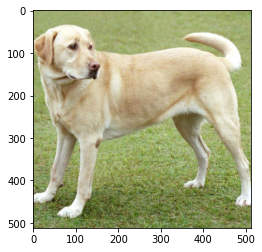

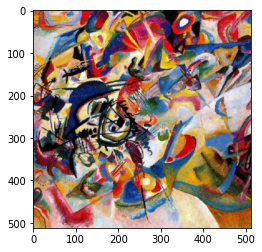

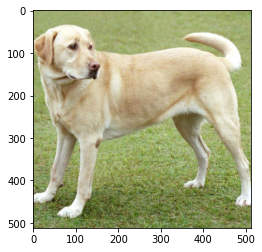

In [ ]:
## Train
# content, style, generated 이미지 정의
content = image_preprocess(content_dir).to(device)
style = image_preprocess(style_dir).to(device)
generated = content.clone().requires_grad_().to(device)

print(content.requires_grad, style.requires_grad, generated.requires_grad)

# 시각화
import matplotlib.pyplot as plt

plt.imshow(image_postprocess(content[0].cpu()))
plt.show()

plt.imshow(image_postprocess(style[0].cpu()))
plt.show()

gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.imshow(gen_img)
plt.show()

In [ ]:
# 목표값 설정
# 행렬의 크기에 따른 가중치 정의
style_target = list(GramMatrix().to(device)(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

In [ ]:
import torch.optim as optim

# Optim: LBFGS
optimizer = optim.LBFGS([generated])

iteration = [0]
while iteration[0] < epoch:
  def closure():
    optimizer.zero_grad()
    out = resnet(generated)

    # style loss function
    style_loss = [GramMSELoss().to(device)(out[i], style_target[i])*style_weight[i] for i in range(len(style_target))]
    # content loss function
    content_loss = nn.MSELoss().to(device)(out[content_layer_num], content_target)
   
    # total loss (hyperparameter: 1000)
    total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)
    total_loss.backward()

    if iteration[0] % 100 == 0:
      print(total_loss)
    iteration[0] += 1
    return total_loss
  optimizer.step(closure)


tensor(11170139., device='cuda:0', grad_fn=<AddBackward0>)
tensor(821.6406, device='cuda:0', grad_fn=<AddBackward0>)
tensor(66.6307, device='cuda:0', grad_fn=<AddBackward0>)
tensor(17.8618, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.6422, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.1013, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5834, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.8404, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.3832, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.0829, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.8955, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.7615, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6599, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5796, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5215, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4736, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4018, device='cuda:0', grad_fn=<

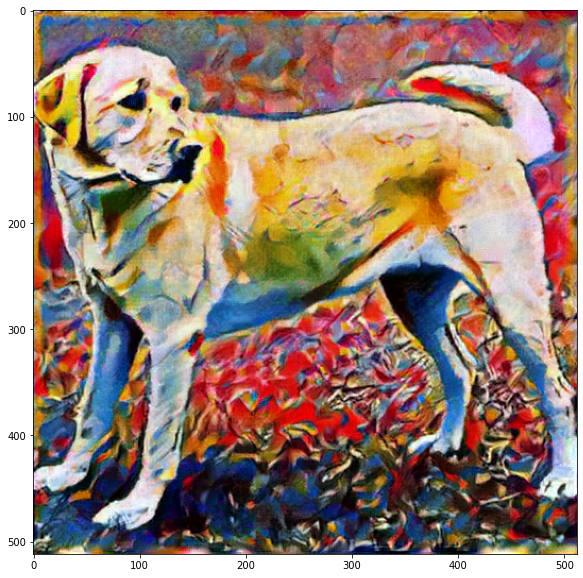

In [ ]:
# show train results

gen_img = image_postprocess(generated[0].cpu()).data.numpy()

plt.figure(figsize=(10,10))
plt.imshow(gen_img)
plt.show()